In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

In [3]:
data = pd.read_csv('data/monthly_unemployment.csv')

In [4]:
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1948,3.4,3.8,4.0,3.9,3.5,3.6,3.6,3.9,3.8,3.7,3.8,4.0
1,1949,4.3,4.7,5.0,5.3,6.1,6.2,6.7,6.8,6.6,7.9,6.4,6.6
2,1950,6.5,6.4,6.3,5.8,5.5,5.4,5.0,4.5,4.4,4.2,4.2,4.3
3,1951,3.7,3.4,3.4,3.1,3.0,3.2,3.1,3.1,3.3,3.5,3.5,3.1
4,1952,3.2,3.1,2.9,2.9,3.0,3.0,3.2,3.4,3.1,3.0,2.8,2.7


In [5]:
m,n = data.shape

x_list, y_list = [],[]

for i in range(m):
    for j in range(1,n):
        x_list.append(pd.to_datetime('%i/%i'%(j, data.iloc[i]['Year'])))
        y_list.append(data.iloc[i][j])

df_array = np.c_[x_list, y_list]
df = pd.DataFrame(df_array, columns=['Date','Rate']).replace({' ':np.nan, '':np.nan}).astype({'Rate':'float64'})

/tmp/ipykernel_16869/1155280562.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_list.append(data.iloc[i][j])


### Handling with missing data

In [6]:
df.isnull().any()

Date    False
Rate     True
dtype: bool

In [204]:
df.isnull().sum()

Date     0
Rate    11
dtype: int64

In [205]:
df.dropna(inplace=True)

In [206]:
df.isnull().sum()

Date    0
Rate    0
dtype: int64

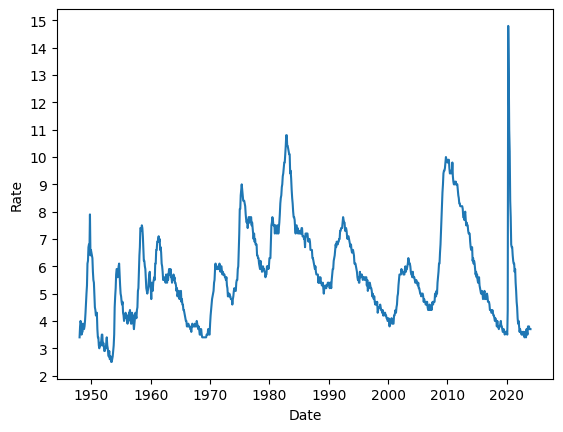

In [207]:
ax = sn.lineplot(df, x='Date', y='Rate')
min_r = int(min(df['Rate']))
max_r = int(max(df['Rate']))
ax.set_yticks(ticks=range(min_r, max_r+2))
plt.show()

In [208]:
df

,Date,Rate
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
908,2023-09-01,3.8
909,2023-10-01,3.8
910,2023-11-01,3.7
911,2023-12-01,3.7


In [209]:
# Read the data
unemp = df.copy()

# Convert DATE column to datetime
# unemp['Date'] = pd.to_datetime(unemp['Date'])

# Sort the DataFrame by DATE
unemp.sort_values(by='Date', inplace=True)

# Generate a data set where data is randomly missing
df_random_miss_idx = np.random.choice(unemp.index, size=int(0.1 * len(unemp)), replace=False)
df_random_miss = unemp.drop(df_random_miss_idx)

# Generate a data set where data is more likely to be missing when unemployment is high
high_unemp_idx = unemp[unemp['Rate'] > 8].index
num_to_select = round(0.2 * len(high_unemp_idx))
high_unemp_idx_sampled = np.random.choice(high_unemp_idx, size=num_to_select, replace=False)
df_random_miss_high = unemp.drop(high_unemp_idx_sampled)

Missing data randomly:

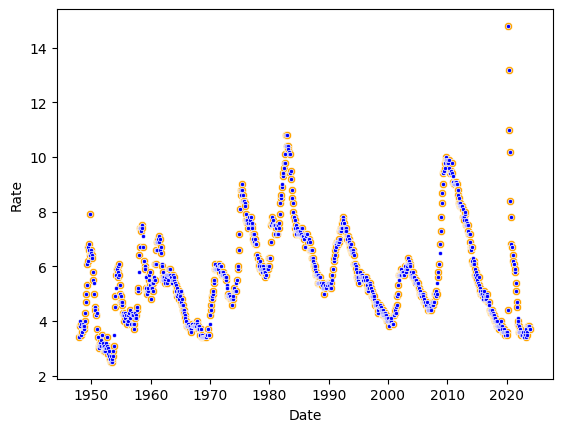

In [210]:
sn.scatterplot(df_random_miss, x='Date', y='Rate', marker='o', color='orange')
sn.scatterplot(df, x='Date', y='Rate', marker='.', color='b')
plt.show()

More likely to miss data when the *Rate* is high:

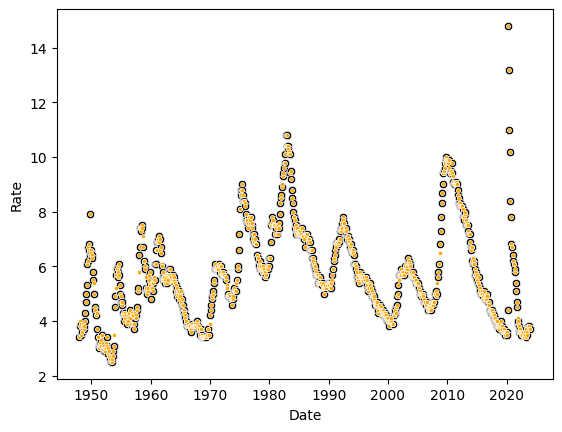

In [211]:
sn.scatterplot(df_random_miss, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(df, x='Date', y='Rate', marker='.', color='orange')
plt.show()

Creating a range of no-missing dates:

In [212]:
dates_random_miss = pd.date_range(start=df.Date.iloc[0], end=df_random_miss.Date.iloc[-1], inclusive='both', freq='MS')
dates_random_miss_high = pd.date_range(start=df.Date.iloc[0], end=df_random_miss.Date.iloc[-1], inclusive='both', freq='MS')

Defining *Date* as the index:

In [213]:
df_random_miss.index = df_random_miss['Date']
df_random_miss.drop(columns='Date', inplace=True)

Changing indices to the non-missing range of dates:

In [214]:
df_random_miss_rid = df_random_miss.Rate.reindex(dates_random_miss, fill_value=np.nan)
df_random_miss_high_rid = df_random_miss.Rate.reindex(dates_random_miss_high, fill_value=np.nan)

In [215]:
df_random_miss_rid.shape

(913,)

`df_random_miss_rid` and `df_random_miss_high_rid` are the dataframes with filled missing values, where any of the following methods will be applied.

#### **Forward fill:**

In [216]:
df_ffill = df_random_miss_rid.ffill().bfill()

In [217]:
df_ffill_high = df_random_miss_high_rid.ffill().bfill()

In [276]:
df_random_miss_rid = df_random_miss_rid.to_frame()
df_ffill = df_ffill.to_frame()

In [218]:
print(df_ffill.shape)
print(df_ffill_high.shape)
print(df.shape)

(913,)
(913,)
(913, 2)


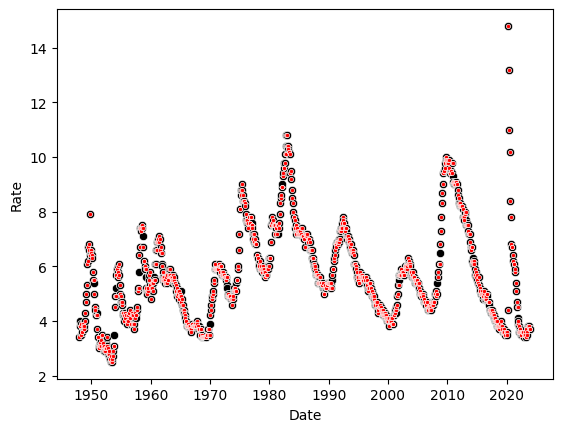

In [219]:
sn.scatterplot(df, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(x=df_ffill.index, y=df_ffill, marker='.', color='r')
plt.show()

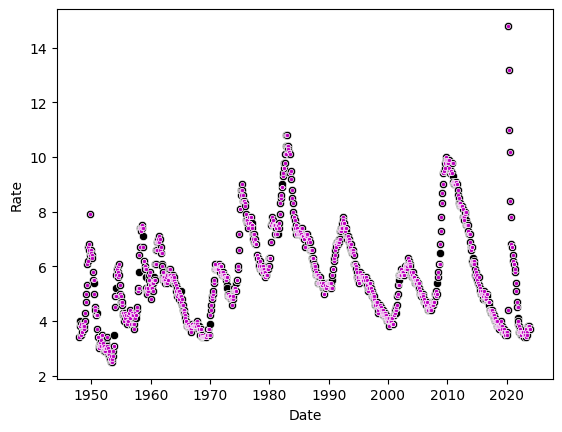

In [220]:
sn.scatterplot(df, x='Date', y='Rate', marker='o', color='k')
sn.scatterplot(x=df_ffill_high.index, y=df_ffill_high, marker='.', color='m')
plt.show()

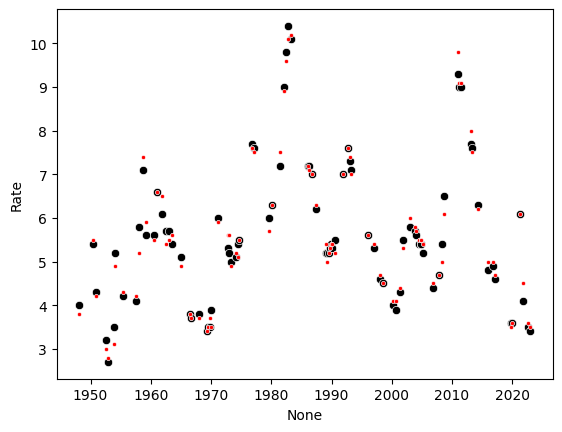

In [277]:
idx = df_random_miss_rid[df_random_miss_rid.isna().Rate].index
df_i = df.copy()

df_i.index = df_i.Date
df_i.drop(columns='Date', inplace=True)
df_i_nans = df_i.loc[idx]

sn.scatterplot(df_i_nans, x=df_i_nans.index, y='Rate', marker='o', color='k')
sn.scatterplot(x=df_ffill.loc[idx].index, y=df_ffill.loc[idx].Rate, marker='.', color='r')
plt.show()

In [278]:
RMSE = np.sqrt(mean_squared_error(df_i_nans.Rate, df_ffill.loc[idx].Rate))
print('RMSE =', RMSE)

RMSE = 0.20054869787605265


#### **Moving average**:

In [221]:
df_ma = df_random_miss_rid.copy().to_frame()
df_ma_high = df_random_miss_high_rid.copy().to_frame()

In [222]:
def moving_average(df_):
    m,n = df_.shape
    for i in range(m):
        x = df_.iloc[i].Rate
        if pd.isna(x):
            df_.iloc[i] = df_.iloc[i-2:i].mean()
    return df_

df_ma_cleaned = moving_average(df_ma.copy())
df_ma_high_cleaned = moving_average(df_ma.copy())

display(df_ma.isna().sum())
display(df_ma_cleaned.isna().sum())
display(df_ma_high_cleaned.isna().sum())

Rate    91
dtype: int64

Rate    0
dtype: int64

Rate    0
dtype: int64

In [249]:
idx = df_ma[df_ma.isna().Rate].index
df_i = df.copy()

df_i.index = df_i.Date
df_i.drop(columns='Date', inplace=True)

Plotting the filled data with **moving average**:

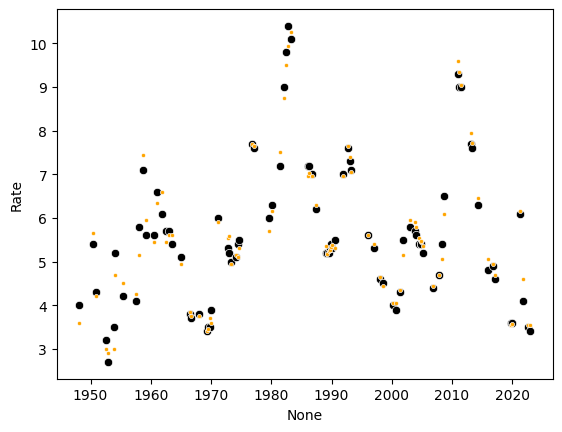

In [258]:
df_i_nans = df_i.loc[idx]

sn.scatterplot(df_i_nans, x=df_i_nans.index, y='Rate', marker='o', color='k')
sn.scatterplot(x=df_ma_cleaned.loc[idx].index, y=df_ma_cleaned.loc[idx].Rate, marker='.', color='orange')
plt.show()

In [266]:
RMSE = np.sqrt(mean_squared_error(df_i_nans.Rate, df_ma_cleaned.loc[idx].Rate))
print('RMSE =', RMSE)

RMSE = 0.22502766160854762


#### **Interpolation**:

In [260]:
df_ip = df_random_miss_rid.copy().to_frame()
df_ip.isna().sum()

Rate    91
dtype: int64

In [262]:
df_ip_cleaned = df_ip.interpolate(limit_direction='forward')
df_ip_cleaned.isna().sum()

Rate    0
dtype: int64

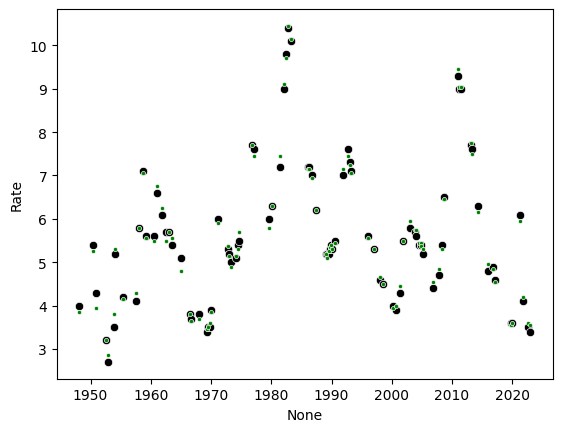

In [263]:
idx = df_ip[df_ip.isna().Rate].index
df_i = df.copy()

df_i.index = df_i.Date
df_i.drop(columns='Date', inplace=True)
df_i_nans = df_i.loc[idx]

sn.scatterplot(df_i_nans, x=df_i_nans.index, y='Rate', marker='o', color='k')
sn.scatterplot(x=df_ip_cleaned.loc[idx].index, y=df_ip_cleaned.loc[idx].Rate, marker='.', color='g')
plt.show()

In [267]:
RMSE = np.sqrt(mean_squared_error(df_i_nans.Rate, df_ip_cleaned.loc[idx].Rate))
print('RMSE =', RMSE)

RMSE = 0.11464762598535627


### Upsampling and Downsampling

In [9]:
df = df.dropna()

**Downsampling**:

In [16]:
m,n = df.shape
idx = [i for i in range(0,m,12)]
df.iloc[idx]

,Date,Rate
0,1948-01-01,3.4
12,1949-01-01,4.3
24,1950-01-01,6.5
36,1951-01-01,3.7
48,1952-01-01,3.2
...,...,...
864,2020-01-01,3.6
876,2021-01-01,6.4
888,2022-01-01,4.0
900,2023-01-01,3.4


In [20]:
df.groupby(by=df.Date.dt.year).agg('mean')

,Date,Rate
Date,,
1948,1948-06-16 08:00:00,3.750000
1949,1949-06-16 12:00:00,6.050000
1950,1950-06-16 12:00:00,5.208333
1951,1951-06-16 12:00:00,3.283333
1952,1952-06-16 08:00:00,3.025000
...,...,...
2020,2020-06-16 08:00:00,8.091667
2021,2021-06-16 12:00:00,5.350000
2022,2022-06-16 12:00:00,3.633333


**Upsampling**:

In [22]:
df_up_samp = df.copy()

In [40]:
df_up_samp.index = df_up_samp.Date

In [44]:
df_up_samp.drop(columns='Date', inplace=True)

In [53]:
df_up_samp = df_up_samp.resample('d').asfreq().ffill()

In [54]:
df_up_samp

,Rate
Date,
1948-01-01,3.4
1948-01-02,3.4
1948-01-03,3.4
1948-01-04,3.4
1948-01-05,3.4
...,...
2023-12-28,3.7
2023-12-29,3.7
2023-12-30,3.7
